Class notes for Feb 20 2019

In [1]:
import tellurium as te
import math
import numpy as np
import matplotlib.pyplot as plt

In [65]:
model LacPath
    compartment cytoplasm;
    cytoplasm = 1.0e-6;
    compartment environment;
    environment = 1.0;
    compartment periplasm;
    periplasm = 1.0e-6;
    species lactose, glucgalac, peri_lactose;
    const species ex_lactose;
    unit M = mole / liter
    unit inv_sec = 1. / seconds
    unit um = 10.e-6 meters
    unit vol_conv = 1000 liter/1 meter^3
    unit dm = 0.01 meters
    #pi = 3.1415;

    lactose = 0.0; # M; free parameter
    glucgalac = 0.0;
    peri_lactose = 0.0;
    ex_lactose = 0.1;

    lactose in cytoplasm; glucgalac in cytoplasm;
    peri_lactose in periplasm;
    ex_lactose in environment

    J34: lactose -> ; kcat*Etot*vol_cell*lactose/(Km+lactose);

    kcat = 6.42e2; #s^-1; from Juers et al (2012)
    Etot = 1e-6; # M; free parameter
    Km = 5.5e-3; # M; from BRENDA

    J12: ex_lactose => peri_lactose; surf_area_peri*permeability*(ex_lactose-peri_lactose);
    J23: peri_lactose => lactose; surf_area*permeability*(peri_lactose-lactose);
    #J31: lactose => ex_lactose; surf_area*permeability*(lactose-ex_lactose)*conversion;

    # cell area/volume calculations

    cell_radius = 400.0e-9 # E coli radius from Bionumbers
    vol_cell = (4/3)*pi*cell_radius^3
    surf_area = 4*pi*cell_radius^2
    #surf_area = 1.0e-10; # dm^2
    peri_thickness = 10.0e-9 # 10nm
    cell_peri_radius = cell_radius+peri_thickness
    vol_peri = ((4/3)*pi*cell_peri_radius^3)-vol_cell
    surf_area_peri = 4*pi*cell_peri_radius^2

    # membrane properties
    permeability = 1.0e-8; # dm s-1

end

Success: Model can be accessed via variable LacPath


In [69]:
LacPath.reset()
LacPath.simulate(start = 0, end = 5.64e14, steps = 1000,selections =['time','[lactose]','[peri_lactose]']) #'S1','J1'
LacPath.plot()

LacPath.steadyStateSelections = ['[lactose]','J34','J12','J23','[peri_lactose]']
values = LacPath.getSteadyStateValues()
selections = LacPath.steadyStateSelections
print(values)
print(selections)

[  8.43155810e-02   1.61569643e-22   1.61569643e-22   1.61569643e-22
   9.23513958e-02]
['[lactose]', 'J34', 'J12', 'J23', '[peri_lactose]']


In [56]:
# this is our calculation to check our numerical calculations
# 1 liter = 1 dm^3
area = 1.0e-10; # dm^2
permeability = 1.0e-8; # dm s-1
km = 5.5e-3; # M
#S1 = 1.0e-2; #M
S1 = np.linspace(1e-3,100e-3,100); # M
kcat = 6.42e2; # s-1
etot = 1.0e-6; # M
vol_cell = 1.0e-15; # L or dm^3
a = area * permeability;
b = km*area*permeability-area*permeability*S1+kcat*etot*vol_cell;
c = -1*km*area*permeability*S1;
S3_ss=(-b+(b**2-4*a*c)**0.5)/(2*a);
#print(a,b,c)
#print('S3_ss',S3_ss)
#plt.plot(S1,S3_ss)
#plt.ylabel('Internal lactose (M)')
#plt.xlabel('External lactose (M)')
te.plot(S1,S3_ss,logx=True,logy=False) # te.plot seems to ignore requests to set logy=False

# or try this by taking the log of the values and then plot
logS1 = np.log10(S1) # log() is the natural log!
logS3ss = np.log10(S3_ss)

te.plot(logS1,logS3ss)

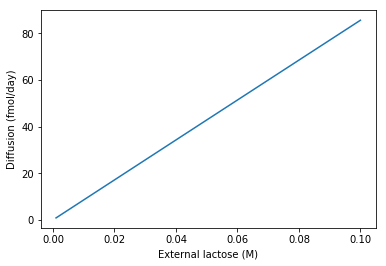

In [57]:
J_ss1=area*permeability*(S1-S3_ss)*(60*60*24)*10e15;#fmol/day
#print('J_ss1',J_ss1)
J_ss2=(kcat*etot*vol_cell*S3_ss)/(km+S3_ss)*(60*60*24)*10e15; #fmol/day
#print('J_ss2',J_ss2)
plt.plot(S1,J_ss1)
plt.xlabel('External lactose (M)')
plt.ylabel('Diffusion (fmol/day)')

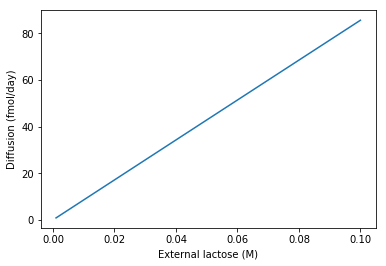

In [58]:
J_ss1=area*permeability*(S1-S3_ss)*(60*60*24)*10e15;#fmol/day
#print('J_ss1',J_ss1)
J_ss2=(kcat*etot*vol_cell*S3_ss)/(km+S3_ss)*(60*60*24)*10e15; #fmol/day
#print('J_ss2',J_ss2)
plt.plot(S1,J_ss1)
plt.xlabel('External lactose (M)')
plt.ylabel('Diffusion (fmol/day)')

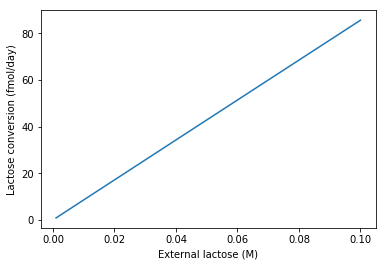

In [59]:
plt.plot(S1,J_ss2)
plt.xlabel('External lactose (M)')
plt.ylabel('Lactose conversion (fmol/day)')

In [62]:
J_ss1=area*permeability*(S1-S3_ss)
culture_volume_mL = 10 # mL
culture_volume_L = culture_volume_mL * 1e-3
cell_density = 1e9 # cells per mL
cell_number = cell_density * culture_volume_mL
k_ss = J_ss1 * (1/S1) * (1/culture_volume_L) * cell_number
half_life_ss = -1 * np.log(0.5) / k_ss
half_life_days = half_life_ss /(60*60*24) #convert from seconds to days
te.plot(S1,half_life_ss)
te.plot(S1,half_life_days)
#print('steady state rate per cell',J_ss1)
#print('steady state rate constant per culture',k_ss)
#print('half life in secs',half_life_ss)
#print('cell numbers',cell_number)
#print('moles of initial lactose',(S1) * (culture_volume_L))